# Processing of the data from the dataset

Here we want to make a sample file and merge the files together to be able to impute the protein data from missing files.

 
1. Go to PDC  (https://proteomic.datacommons.cancer.gov/pdc/)
2. Select "Clear Cell Renal Cell Carcinoma" from the "Cases by Disease Type" tab
3. Find the PDC study ID "PDC000411" and scroll the bar at the bottom to the right to find the column named "Metadata"
4. Click on the number "14" under the "Metadata" column
5. Download "Supplementary_Processed_Proteomic_Data_for_PMID-36563681.zip"; this contains all the proteomic data matrices used in our published paper
6. Download "Supplementary_Processed_Genomic_Transcriptomic_Data_for_PMID-36563681.zip"; this contains all the genomic and transcriptomic data

`Genes, C3L-00165_N, C3L-00165_T`

We need to make a sample dataframe with the following columns to make our life easier:
```
CondId <- 'CondID'
FullLabel <- 'Sample'
CaseId <- 'SafeCases'
paired=FALSE
gene = 'gene_name'
```
For the protein file


Clear cell renal cell carcinomas (ccRCCs) represent ~75% of RCC cases and account for most RCC-associated deaths. Inter- and intra-tumoral heterogeneity (ITH) results in varying prognosis and treatment outcomes. Prior large-scale ccRCC studies evaluated either histologic variation or molecular profiles. To obtain a more comprehensive profile of ccRCC, we carried out integrative histopathologic, proteogenomic, and metabolomic analyses from 305 ccRCC tumor segments and 166 paired normal adjacent tissues from 213 cases. Combining histologic and molecular profiles revealed ITH in 90% of ccRCCs, with 50% demonstrating immune signature heterogeneity. High tumor grade along with BAP1 mutation, genome instability, increased hypermethylation, and a specific protein glycosylation signature defined a new high-risk disease subset, where UCHL1 expression displayed prognostic value. Single nuclei RNA-seq of the adverse sarcomatoid and rhabdoid phenotypes uncovered gene signatures and potential insights into tumor evolution. This study molecularly stratifies an aggressive ccRCC subtype that may inform more effective treatment strategies.

https://proteomic.datacommons.cancer.gov/pdc/study/PDC000414

In [9]:
import pandas as pd
old_cases = pd.read_csv('old_cases.csv')['SafeCases']
old_cases

0      C3L.00004
1      C3L.00004
2      C3L.00010
3      C3L.00010
4      C3L.00011
         ...    
129    C3N.01649
130    C3N.01649
131    C3N.01651
132    C3N.01808
133    C3N.01808
Name: SafeCases, Length: 134, dtype: object

In [10]:
stages = pd.read_csv('SupTable2_meta_table.csv')
stages['SafeCases'] = [c.replace('-', '.') for c in stages['CASE_ID'].values]

In [11]:
case_to_stage = dict(zip(stages.SafeCases, stages.Tumor_stage))#set(list(stages['CASE_ID'].values))&set(ith_cases)

In [94]:
import pandas as pd
cancer = 'ClearCellRenalCellCarcinoma-New'


rna_n = pd.read_csv('input_data/CPTAC_ccRCC_combined_NAT_mRNA_readcount_v1.0.tsv', sep='\t')
rna_t = pd.read_csv('input_data/CPTAC_ccRCC_combined_tumor_mRNA_readcount_v1.0.tsv', sep='\t')
# Use the RNA data to make the sample dataframes
rows = []
for sample in rna_t:
    if 'gene' not in sample:
        safe_case = sample[:-2].replace('-', '.')
        cond_id = 1
        stage = case_to_stage.get(safe_case)
        full_label = f'{safe_case}_Tumor_RNA'

        rows.append([sample, full_label, safe_case, cond_id, stage])
    
# Do the same for normal
for sample in rna_n:
    if 'gene' not in sample:
        full_label = sample.replace('-', '.').replace('_', '.')
        safe_case = sample[:-2].replace('-', '.')
        cond_id = 0
        stage = case_to_stage.get(safe_case)
        full_label = f'{safe_case}_Normal_RNA'
        rows.append([sample, full_label, safe_case, cond_id, stage])

sample_df = pd.DataFrame(rows, columns=['FullLabel', 'Sample', 'SafeCases', 'CondID', 'TumorStage'])
print(len(sample_df))
sample_df = sample_df[~sample_df.SafeCases.isin(old_cases)]


373


In [95]:
sample_df

,FullLabel,Sample,SafeCases,CondID,TumorStage
3,C3L-00026-T,C3L.00026_Tumor_RNA,C3L.00026,1,Stage I
10,C3L-00359-T,C3L.00359_Tumor_RNA,C3L.00359,1,None
22,C3L-00610-T,C3L.00610_Tumor_RNA,C3L.00610,1,Stage I
23,C3L-00765-T,C3L.00765_Tumor_RNA,C3L.00765,1,Stage I
24,C3L-00766-T,C3L.00766_Tumor_RNA,C3L.00766,1,Stage I
...,...,...,...,...,...
368,C3N-02811-A,C3N.02811_Normal_RNA,C3N.02811,0,Stage I
369,C3N-02945-A,C3N.02945_Normal_RNA,C3N.02945,0,Stage III
370,C3N-03018-A,C3N.03018_Normal_RNA,C3N.03018,0,Stage I
371,C3N-03019-A,C3N.03019_Normal_RNA,C3N.03019,0,Stage I


In [68]:
rna_n.drop_duplicates(subset='gene_name', inplace=True)
rna_t.drop_duplicates(subset='gene_name', inplace=True)

rna_t.set_index('gene_name', inplace=True)
rna_t.drop(columns=['gene_id'], inplace=True)
rna_n.set_index('gene_name', inplace=True)
rna_df = rna_n.join(rna_t, how='inner')
rna_df

,gene_id,C3L-00004-A,C3L-00010-A,C3L-00011-A,C3L-00026-A,C3L-00079-A,C3L-00088-A,C3L-00096-A,C3L-00097-A,C3L-00103-A,...,C3N-02723-T,C3N-02726-T,C3N-02761-T,C3N-02763-T,C3N-02811-T,C3N-02945-T,C3N-03018-T,C3N-03019-T,C3N-03020-T,C3N-03021-T
gene_name,,,,,,,,,,,,,,,,,,,,,
DDX11L1,ENSG00000223972.5,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
WASH7P,ENSG00000227232.5,72,114,59,72,49,89,61,72,50,...,86,74,49,85,77,111,91,74,77,71
MIR6859-3,ENSG00000278267.1,10,22,11,14,25,22,13,17,8,...,10,11,14,17,26,34,23,11,15,17
RP11-34P13.3,ENSG00000243485.3,0,0,0,0,0,0,0,0,0,...,0,0,0,4,0,0,0,0,0,0
MIR1302-9,ENSG00000274890.1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND6,ENSG00000198695.2,1284,1863,1019,1602,398,1079,966,2247,831,...,203,321,214,1391,682,322,854,764,3349,1709
MT-TE,ENSG00000210194.1,18,17,11,15,2,28,10,54,7,...,3,5,12,147,11,1,18,23,400,6
MT-CYB,ENSG00000198727.2,75552,56189,84892,79443,40387,89671,57890,106037,55448,...,6005,8986,3888,22765,18773,8042,8658,4553,6024,83507


In [69]:
rna_df.rename(columns=dict(zip(sample_df.FullLabel, sample_df.Sample)), inplace=True)


/Users/arianemora/miniconda3/envs/sircle/lib/python3.10/site-packages/sciviso/scatterplot.py:114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(vis_df[x].values, vis_df[y].values, c=self.colour, alpha=self.opacity,


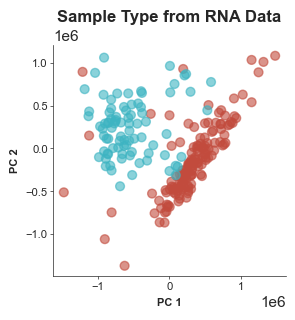

In [70]:
from sciviso import *
from sklearn.decomposition import PCA
import os
import matplotlib.pyplot as plt
import numpy as np

cols = list(sample_df['Sample'].values)

vals = rna_df[cols].values.T

# For vis replace Nan with mean - we'll impute later
vals = np.nan_to_num(vals, np.mean(np.mean(vals)))

pca = PCA(n_components=2)
pca_values = pca.fit_transform(vals)
var_ratio = pca.fit(vals).explained_variance_ratio_
plt.rcParams['figure.figsize'] = [4, 4]
vis_df = pd.DataFrame()
vis_df['PC_1'] = pca_values[:, 0]
vis_df['PC_2'] = pca_values[:, 1]
vis_df['CondID'] = sample_df['CondID'].values
vis_df['Colour'] = ['#C24B3D' if c == 1 else '#3DB4C2' for c in vis_df['CondID'].values]

sc = Scatterplot(vis_df, x='PC_1', y='PC_2', title=f'Sample Type from RNA Data', xlabel='PC 1', ylabel='PC 2',
                 add_legend=True, colour=vis_df['Colour'].values,
                 config={'s': 40, 'opacity': 0.6, 'figsize': (3, 3)})
sc.plot()
fig_dir = ''
plt.savefig(os.path.join(fig_dir, f'{cancer}_RNA_scatterPCASampleType.svg'))
plt.show()

--------------------------------------------------------------------------------
            RNA size: 	(58387, 374)	Mean counts:	672.6934028429341	             
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
           RNA size after dropping missing gene names: 	(58387, 374)	           
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                 RNA size after 10 count filter: 	(24270, 374)	                 
--------------------------------------------------------------------------------


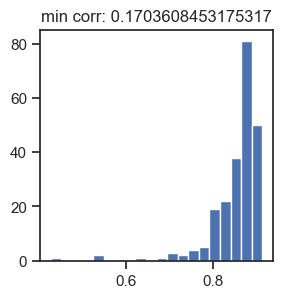

--------------------------------------------------------------------------------
               RNA size after correlation filter: 	(24270, 374)	                
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                             RNA columns to omit: 	                             
--------------------------------------------------------------------------------
C3L.00976_Tumor_RNA
--------------------------------------------------------------------------------
                RNA shape after dropping columns:	(24270, 373)	                 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
               After dropping rows with 50% nulls:	(24270, 373)	                
--------------------------------------------------------------------------------


In [96]:
from sciutil import *
u = SciUtil()
cols = list(sample_df['Sample'].values)
df = rna_df
rna_sample_df = sample_df
mean_rna = np.nanmean(df[cols].values, axis=1)
u.dp(['RNA size: ', df.shape, 'Mean counts:', np.mean(mean_rna)])

u.dp(['RNA size after dropping missing gene names: ', df.shape])

df = df[mean_rna > 10]
u.dp(['RNA size after 10 count filter: ', df.shape])

corr = df[cols].corr()

# Print out the minimum correlation:
mean_cor = np.nanmean(corr, axis=1)
corr['mean_corr'] = mean_cor
corr.sort_values(by=['mean_corr'])

# Plot out the mean correlation values so we can choose a good filter.
plt.hist(mean_cor, bins=20)
plt.title(f'min corr: {np.min(corr)}')
plt.show()

# Filter the shitty patients
corr_sorted = corr.sort_values(by=['mean_corr'])
corr_sorted = corr_sorted[corr_sorted['mean_corr'] < 0.5]

u.dp(['RNA size after correlation filter: ', df.shape])

cols_to_omit = [c for c in corr_sorted.index]

u.dp(['RNA columns to omit: '])

print('\n'.join(cols_to_omit))

cols_to_keep = [c for c in df.columns if c not in cols_to_omit]
df = df[cols_to_keep]


u.dp(['RNA shape after dropping columns:', df.shape])

# Drop RNA samples with > 50% missing values
df = df[df.isnull().sum(axis=1) < len(df.values[0])/2]

u.dp(['After dropping rows with 50% nulls:', df.shape])

# Filter sample df to only include those samples
sample_df = rna_sample_df[rna_sample_df['Sample'].isin(cols_to_keep)]

# Fill NAs with 0's
df = df.fillna(0)

In [97]:
df = df[['gene_id'] + list(sample_df['Sample'].values)]
df.to_csv(f'{cancer}_filtered_RNA.csv')

In [98]:
sample_df.to_csv(f'{cancer}_filtered_samples_RNA.csv', index=False)


In [100]:
len(sample_df)

228

In [99]:
len(df.columns)

229

## Do the protein dataframe

In [101]:
# Now for protein we need to match to the ones in the rna lets see what the column overlap is
df = pd.read_csv('input_data/CPTAC_ccRCC_global_proteome_DIA.tsv', sep='\t')
df

,Genes,C3L-00165_N,C3L-00165_T,C3L-00815_T,C3L-00908_T,C3L-00966_N,C3L-00966_T,C3L-00968_N,C3L-00968_T,C3L-00969_N,...,CPT000741_ITH_01,CPT000733_ITH_01,CPT000691_ITH_01,CPT000686_ITH_01,CPT000667_ITH_01,CPT000664_ITH_01,CPT000652_ITH_01,CPT000647_ITH_01,CPT000065_ITH_01,CPT000063_ITH_01
0,A1BG,3.333140e+07,3.702989e+07,3.860230e+07,3.651085e+07,2.386829e+07,4.309756e+07,6.091547e+07,1.321102e+07,5.225839e+07,...,4.082325e+07,4.242120e+07,8.243881e+07,8.724577e+07,5.057679e+07,6.437656e+07,3.697637e+07,5.224646e+07,7.607053e+07,1.251288e+08
1,A1CF,NaN,NaN,NaN,4.504970e+05,1.357352e+06,2.038736e+06,9.505131e+05,NaN,1.510229e+06,...,1.094378e+06,1.200024e+06,2.174292e+06,1.900415e+06,1.155530e+06,1.941204e+06,7.632773e+05,7.720854e+05,7.874175e+05,NaN
2,A2M,1.493675e+08,2.009495e+08,2.328035e+08,1.559054e+08,8.827605e+07,9.951211e+07,1.051681e+08,3.338940e+07,7.767712e+07,...,7.385097e+07,5.467512e+07,1.180987e+08,1.346090e+08,1.924597e+08,2.736052e+08,1.363851e+08,1.456744e+08,1.016423e+08,2.186016e+08
3,A4GALT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAAS,1.660683e+06,1.947963e+06,NaN,NaN,1.222075e+06,1.302880e+06,1.048631e+06,2.425194e+06,1.293137e+06,...,1.601510e+06,1.615242e+06,1.577130e+06,1.573718e+06,1.157621e+06,1.643074e+06,1.700431e+06,1.514909e+06,1.604220e+06,1.464925e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8357,ZW10,1.537631e+06,7.930233e+05,1.210563e+06,8.608684e+05,1.255517e+06,1.052006e+06,1.106198e+06,1.778118e+06,1.326142e+06,...,1.431121e+06,1.551453e+06,1.217611e+06,1.168007e+06,1.009284e+06,1.268956e+06,1.309416e+06,1.014828e+06,1.101764e+06,7.076617e+05
8358,ZYG11B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.515601e+05,NaN,...,NaN,NaN,NaN,NaN,8.802501e+04,1.025951e+05,NaN,NaN,NaN,NaN
8359,ZYX,2.291628e+07,2.287395e+07,1.590125e+07,1.178709e+07,1.366999e+07,2.535066e+07,1.878179e+07,4.263365e+07,2.836638e+07,...,2.340559e+07,2.583394e+07,1.511761e+07,1.750901e+07,1.502461e+07,1.861267e+07,1.213164e+07,1.503872e+07,2.036158e+07,2.058848e+07
8360,ZZEF1,8.246465e+05,5.995579e+05,4.822099e+05,5.717840e+05,7.187789e+05,9.092527e+05,6.994505e+05,6.509645e+05,7.314399e+05,...,9.493697e+05,8.881532e+05,6.210994e+05,7.967591e+05,6.466688e+05,8.773500e+05,8.361001e+05,6.070037e+05,8.755445e+05,7.379931e+05


In [103]:
# Change genes to 'gene_name'
df.rename(columns={'Genes': 'gene_name'}, inplace=True)
# Now make sure we have a sample data frame
rows = []
for sample in df.columns:
    if 'C3' in sample:
        safe_case = sample.replace('-', '.').split('_')[0]
        label = sample.replace('-', '.').replace('_', '.')
        cond_id = 0 if '_N' in sample else 1
        if cond_id == 0:
            full_label = f'{safe_case}_Normal_Protein'
        else:
            full_label = f'{safe_case}_Tumor_Protein'
        stage = case_to_stage.get(safe_case)
        rows.append([sample, safe_case, full_label, cond_id, stage])
protein_sample_df = pd.DataFrame(rows, columns=['FullLabel', 'SafeCases', 'Sample', 'CondID', 'TumorStage'])
print(len(protein_sample_df))
protein_sample_df = protein_sample_df[~protein_sample_df.SafeCases.isin(old_cases)]


393


In [104]:
len(protein_sample_df)

240

In [26]:
# Get the sample to the conditon 
protein_sample_df.CondID.value_counts()

CondID
1    145
0     95
Name: count, dtype: int64

In [27]:
protein_sample_df.to_csv(f'{cancer}_filtered_samples_Protein.csv')

## Filter out values that are mostly 0 before imputing

In [28]:
df.set_index('gene_name', inplace=True)
df = df.dropna(thresh=int(len(df.columns)/2))
df

,C3L-00165_N,C3L-00165_T,C3L-00815_T,C3L-00908_T,C3L-00966_N,C3L-00966_T,C3L-00968_N,C3L-00968_T,C3L-00969_N,C3L-00969_T,...,CPT000741_ITH_01,CPT000733_ITH_01,CPT000691_ITH_01,CPT000686_ITH_01,CPT000667_ITH_01,CPT000664_ITH_01,CPT000652_ITH_01,CPT000647_ITH_01,CPT000065_ITH_01,CPT000063_ITH_01
gene_name,,,,,,,,,,,,,,,,,,,,,
A1BG,3.333140e+07,3.702989e+07,3.860230e+07,3.651085e+07,2.386829e+07,4.309756e+07,6.091547e+07,1.321102e+07,5.225839e+07,2.762951e+07,...,4.082325e+07,4.242120e+07,8.243881e+07,8.724577e+07,5.057679e+07,6.437656e+07,3.697637e+07,5.224646e+07,7.607053e+07,1.251288e+08
A1CF,NaN,NaN,NaN,4.504970e+05,1.357352e+06,2.038736e+06,9.505131e+05,NaN,1.510229e+06,NaN,...,1.094378e+06,1.200024e+06,2.174292e+06,1.900415e+06,1.155530e+06,1.941204e+06,7.632773e+05,7.720854e+05,7.874175e+05,NaN
A2M,1.493675e+08,2.009495e+08,2.328035e+08,1.559054e+08,8.827605e+07,9.951211e+07,1.051681e+08,3.338940e+07,7.767712e+07,7.349916e+07,...,7.385097e+07,5.467512e+07,1.180987e+08,1.346090e+08,1.924597e+08,2.736052e+08,1.363851e+08,1.456744e+08,1.016423e+08,2.186016e+08
AAAS,1.660683e+06,1.947963e+06,NaN,NaN,1.222075e+06,1.302880e+06,1.048631e+06,2.425194e+06,1.293137e+06,NaN,...,1.601510e+06,1.615242e+06,1.577130e+06,1.573718e+06,1.157621e+06,1.643074e+06,1.700431e+06,1.514909e+06,1.604220e+06,1.464925e+06
AACS,1.142895e+06,3.419676e+06,1.069860e+06,1.880704e+06,1.779413e+06,9.919288e+05,1.777641e+06,1.774738e+06,1.056235e+06,1.618279e+06,...,1.762790e+06,1.943830e+06,3.044022e+06,2.578803e+06,1.728836e+06,1.469623e+06,1.177658e+06,1.432337e+06,1.515310e+06,1.005574e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZRANB2,2.850045e+06,3.017500e+06,1.834309e+06,1.002693e+06,1.839865e+06,2.162780e+06,1.672111e+06,2.134800e+06,2.276557e+06,1.757294e+06,...,1.420278e+06,1.513811e+06,1.260476e+06,1.305692e+06,9.696440e+05,1.336026e+06,1.935579e+06,1.878751e+06,1.903282e+06,1.989858e+06
ZSCAN18,3.208751e+05,7.143692e+05,1.070707e+06,6.672460e+05,6.941821e+05,9.013995e+05,7.765187e+05,2.772606e+05,5.145291e+05,8.020991e+05,...,1.954560e+05,2.082860e+05,3.541176e+05,3.006196e+05,3.723483e+05,3.672978e+05,NaN,1.978136e+05,NaN,1.824339e+05
ZW10,1.537631e+06,7.930233e+05,1.210563e+06,8.608684e+05,1.255517e+06,1.052006e+06,1.106198e+06,1.778118e+06,1.326142e+06,1.521596e+06,...,1.431121e+06,1.551453e+06,1.217611e+06,1.168007e+06,1.009284e+06,1.268956e+06,1.309416e+06,1.014828e+06,1.101764e+06,7.076617e+05


In [29]:
protein_sample_df

,FullLabel,SafeCases,Sample,CondID,TumorStage
0,C3L-00165_N,C3L.00165,C3L.00165_Normal_Protein,0,Stage III
1,C3L-00165_T,C3L.00165,C3L.00165_Tumor_Protein,1,Stage III
2,C3L-00815_T,C3L.00815,C3L.00815_Tumor_Protein,1,Stage I
4,C3L-00966_N,C3L.00966,C3L.00966_Normal_Protein,0,Stage I
5,C3L-00966_T,C3L.00966,C3L.00966_Tumor_Protein,1,Stage I
...,...,...,...,...,...
370,C3N-01213_T,C3N.01213,C3N.01213_Tumor_Protein,1,Stage III
381,C3N-01524_N,C3N.01524,C3N.01524_Normal_Protein,0,Stage II
382,C3N-01524_T,C3N.01524,C3N.01524_Tumor_Protein,1,Stage II
385,C3N-01648_N,C3N.01648,C3N.01648_Normal_Protein,0,Stage II


## Note we assume all ITH are tumour as this is what it appears like in the sample file: 

In [30]:
df.rename(columns=dict(zip(protein_sample_df.FullLabel, protein_sample_df.Sample)), inplace=True)
df = df[list(protein_sample_df.Sample.values)]
df.to_csv(f'{cancer}_filtered_Protein.csv')

/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_48755/4007105350.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns=dict(zip(protein_sample_df.FullLabel, protein_sample_df.Sample)), inplace=True)


# Read in the imputed file and then log transform

In [105]:
import numpy as np
df = pd.read_csv(f'{cancer}_filtered_imputed_Protein.csv')
df.rename(columns={'Unnamed: 0': 'gene_name'}, inplace=True)
df.set_index('gene_name', inplace=True)
for c in df.columns:
    df[c] = np.log2(df[c].values+1)

/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_48755/2723722261.py:6: RuntimeWarning: invalid value encountered in log2
  df[c] = np.log2(df[c].values+1)


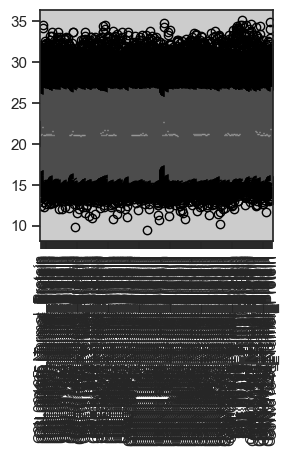

In [53]:
import matplotlib.pyplot as plt
df.boxplot()
plt.xticks(rotation=90)
plt.show()


/Users/arianemora/miniconda3/envs/sircle/lib/python3.10/site-packages/sciviso/scatterplot.py:114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(vis_df[x].values, vis_df[y].values, c=self.colour, alpha=self.opacity,


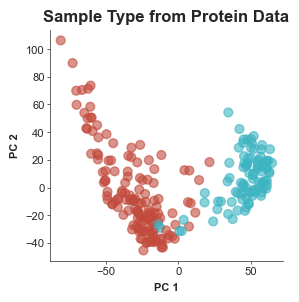

In [54]:
from sciviso import *
from sklearn.decomposition import PCA
sample_df = protein_sample_df
import os
cols = list(sample_df['Sample'].values)

vals = df[cols].values.T

# For vis replace Nan with mean - we'll impute later
vals = np.nan_to_num(vals, np.mean(np.mean(vals)))

pca = PCA(n_components=2)
pca_values = pca.fit_transform(vals)
var_ratio = pca.fit(vals).explained_variance_ratio_
plt.rcParams['figure.figsize'] = [4, 4]
vis_df = pd.DataFrame()
vis_df['PC_1'] = pca_values[:, 0]
vis_df['PC_2'] = pca_values[:, 1]
vis_df['CondID'] = sample_df['CondID'].values
vis_df['Colour'] = ['#C24B3D' if c == 1 else '#3DB4C2' for c in vis_df['CondID'].values]

sc = Scatterplot(vis_df, x='PC_1', y='PC_2', title=f'Sample Type from Protein Data', xlabel='PC 1', ylabel='PC 2',
                 add_legend=True, colour=vis_df['Colour'].values,
                 config={'s': 40, 'opacity': 0.6, 'figsize': (3, 3)})
sc.plot()
fig_dir = ''
plt.savefig(os.path.join(fig_dir, f'{cancer}_Protein_scatterPCASampleType.svg'))
plt.show()

In [55]:
df.to_csv(f'{cancer}_filtered_imputed-norm_Protein.csv')

## Make a sample DF for the RNAseq and the DNA methylation data

These were provided as half the normal and half the tumour.



In [106]:
meth_n = pd.read_csv('input_data/CPTAC_ccRCC_combined_NAT_methylation_betavalue_probe_level_v1.0.tsv', sep='\t')
meth_t = pd.read_csv('input_data/CPTAC_ccRCC_combined_tumor_methylation_betavalue_probe_level_v1.0.tsv', sep='\t')
meth_n

,Locus,C3L-00416-A,C3L-00907-A,C3L-00910-A,C3L-00917-A,C3L-01286-A,C3L-01836-A,C3N-00149-A,C3N-00150-A,C3N-00242-A,C3N-00733-A,C3N-00852-A,C3N-01200-A
0,cg00000029,0.389764,0.378061,0.365246,0.336589,0.343964,0.231075,0.348554,0.330673,0.410918,0.381937,0.324472,0.474368
1,cg00000109,0.826114,0.873441,0.862814,0.887749,0.845409,0.835886,0.848502,0.846213,0.851399,0.868610,0.826555,0.867055
2,cg00000155,0.922119,0.916398,0.915430,0.927740,0.918910,0.917042,0.917669,0.909127,0.913459,0.904269,0.905254,0.912797
3,cg00000158,0.863382,0.808893,0.892305,0.773254,0.796770,0.872534,0.838733,0.827604,0.845652,0.898172,0.894210,0.894253
4,cg00000165,0.097204,0.082465,0.130732,0.106095,0.135131,0.104386,0.112848,0.110908,0.106880,0.106381,0.114852,0.095437
...,...,...,...,...,...,...,...,...,...,...,...,...,...
917432,ch.X.97129969R,0.115797,0.146129,0.055815,0.139683,0.144083,0.147510,0.050538,0.086967,0.141758,0.122712,0.158137,0.068394
917433,ch.X.97133160R,0.190919,0.203582,0.106875,0.161075,0.219337,0.216368,0.104793,0.026592,0.269385,0.189496,0.073926,0.086115
917434,ch.X.97651759F,0.028147,0.027836,0.026470,0.032428,0.067031,0.029085,0.027101,0.009006,0.035902,0.033531,0.026500,0.020975
917435,ch.X.97737721F,0.059945,0.077683,0.085384,0.083484,0.061631,0.093759,0.077886,0.070595,0.087545,0.078797,0.069925,0.075599


In [107]:
meth_n.drop_duplicates(subset='Locus', inplace=True)
meth_t.drop_duplicates(subset='Locus', inplace=True)

meth_t.set_index('Locus', inplace=True)
meth_n.set_index('Locus', inplace=True)
meth_df = meth_n.join(meth_t, how='inner')
meth_df

,C3L-00416-A,C3L-00907-A,C3L-00910-A,C3L-00917-A,C3L-01286-A,C3L-01836-A,C3N-00149-A,C3N-00150-A,C3N-00242-A,C3N-00733-A,...,C3N-02723-T,C3N-02726-T,C3N-02761-T,C3N-02763-T,C3N-02811-T,C3N-02945-T,C3N-03018-T,C3N-03019-T,C3N-03020-T,C3N-03021-T
Locus,,,,,,,,,,,,,,,,,,,,,
cg00000029,0.389764,0.378061,0.365246,0.336589,0.343964,0.231075,0.348554,0.330673,0.410918,0.381937,...,0.411925,0.444012,0.337082,0.570233,0.365759,0.316070,0.393935,0.288154,0.676817,0.262431
cg00000109,0.826114,0.873441,0.862814,0.887749,0.845409,0.835886,0.848502,0.846213,0.851399,0.868610,...,0.826499,0.620154,0.820035,0.639597,0.599622,0.475616,0.369462,0.757804,0.661171,0.852063
cg00000155,0.922119,0.916398,0.915430,0.927740,0.918910,0.917042,0.917669,0.909127,0.913459,0.904269,...,0.928009,0.910009,0.927637,0.935045,0.919840,0.926848,0.718042,0.916902,0.924569,0.931407
cg00000158,0.863382,0.808893,0.892305,0.773254,0.796770,0.872534,0.838733,0.827604,0.845652,0.898172,...,0.816897,0.626768,0.735793,0.578202,0.761671,0.580767,0.659568,0.567702,0.487106,0.448556
cg00000165,0.097204,0.082465,0.130732,0.106095,0.135131,0.104386,0.112848,0.110908,0.106880,0.106381,...,0.228051,0.167967,0.087837,0.081238,0.347296,0.086564,NaN,0.224560,0.074014,0.084169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ch.X.97129969R,0.115797,0.146129,0.055815,0.139683,0.144083,0.147510,0.050538,0.086967,0.141758,0.122712,...,0.048790,0.094084,0.163127,0.083743,0.097412,0.009941,0.105870,0.087724,0.087858,0.117626
ch.X.97133160R,0.190919,0.203582,0.106875,0.161075,0.219337,0.216368,0.104793,0.026592,0.269385,0.189496,...,0.183100,0.242202,0.186219,0.107361,0.115340,0.141017,NaN,0.245311,0.160291,0.187966
ch.X.97651759F,0.028147,0.027836,0.026470,0.032428,0.067031,0.029085,0.027101,0.009006,0.035902,0.033531,...,0.016796,0.030300,0.029658,0.028596,0.025355,0.028433,0.020822,0.020042,0.029571,0.036241


In [108]:
# Use the RNA data to make the sample dataframes
rows = []
for sample in meth_t:
    full_label = sample.replace('-', '.').replace('_', '.')
    safe_case = sample[:-2].replace('-', '.')
    cond_id = 1
    stage = case_to_stage.get(safe_case)
    full_label = f'{safe_case}_Tumor_CpG'
    rows.append([sample, full_label, safe_case, cond_id, stage])
   

sample_df = pd.DataFrame(rows, columns=['FullLabel', 'Sample', 'SafeCases', 'CondID', 'TumorStage'])
print(len(sample_df))
sample_df = sample_df[~sample_df.SafeCases.isin(old_cases)]
print(len(sample_df))
rows = []

normal_meth_cases = []
# Do the same for normal
for sample in meth_n:
    full_label = sample.replace('-', '.').replace('_', '.')
    safe_case = sample[:-2].replace('-', '.')
    cond_id = 0
    stage = case_to_stage.get(safe_case)
    full_label = f'{safe_case}_Normal_CpG'
    normal_meth_cases.append(safe_case)
    rows.append([sample, full_label, safe_case, cond_id, stage])

sample_df2 = pd.DataFrame(rows, columns=['FullLabel', 'Sample', 'SafeCases', 'CondID', 'TumorStage'])
sample_df = pd.concat([sample_df, sample_df2], ignore_index=True)
sample_df

222
146


,FullLabel,Sample,SafeCases,CondID,TumorStage
0,C3L-00026-T,C3L.00026_Tumor_CpG,C3L.00026,1,Stage I
1,C3L-00165-T,C3L.00165_Tumor_CpG,C3L.00165,1,Stage III
2,C3L-00359-T,C3L.00359_Tumor_CpG,C3L.00359,1,None
3,C3L-00610-T,C3L.00610_Tumor_CpG,C3L.00610,1,Stage I
4,C3L-00765-T,C3L.00765_Tumor_CpG,C3L.00765,1,Stage I
...,...,...,...,...,...
153,C3N-00150-A,C3N.00150_Normal_CpG,C3N.00150,0,Stage IV
154,C3N-00242-A,C3N.00242_Normal_CpG,C3N.00242,0,Stage I
155,C3N-00733-A,C3N.00733_Normal_CpG,C3N.00733,0,Stage III
156,C3N-00852-A,C3N.00852_Normal_CpG,C3N.00852,0,Stage III


In [81]:
len(meth_n.columns)

12

In [83]:
meth_n

,C3L-00416-A,C3L-00907-A,C3L-00910-A,C3L-00917-A,C3L-01286-A,C3L-01836-A,C3N-00149-A,C3N-00150-A,C3N-00242-A,C3N-00733-A,C3N-00852-A,C3N-01200-A
Locus,,,,,,,,,,,,
cg00000029,0.389764,0.378061,0.365246,0.336589,0.343964,0.231075,0.348554,0.330673,0.410918,0.381937,0.324472,0.474368
cg00000109,0.826114,0.873441,0.862814,0.887749,0.845409,0.835886,0.848502,0.846213,0.851399,0.868610,0.826555,0.867055
cg00000155,0.922119,0.916398,0.915430,0.927740,0.918910,0.917042,0.917669,0.909127,0.913459,0.904269,0.905254,0.912797
cg00000158,0.863382,0.808893,0.892305,0.773254,0.796770,0.872534,0.838733,0.827604,0.845652,0.898172,0.894210,0.894253
cg00000165,0.097204,0.082465,0.130732,0.106095,0.135131,0.104386,0.112848,0.110908,0.106880,0.106381,0.114852,0.095437
...,...,...,...,...,...,...,...,...,...,...,...,...
ch.X.97129969R,0.115797,0.146129,0.055815,0.139683,0.144083,0.147510,0.050538,0.086967,0.141758,0.122712,0.158137,0.068394
ch.X.97133160R,0.190919,0.203582,0.106875,0.161075,0.219337,0.216368,0.104793,0.026592,0.269385,0.189496,0.073926,0.086115
ch.X.97651759F,0.028147,0.027836,0.026470,0.032428,0.067031,0.029085,0.027101,0.009006,0.035902,0.033531,0.026500,0.020975


In [84]:
sample_df['CondID'].value_counts()

CondID
1    146
0     12
Name: count, dtype: int64

In [85]:
meth_df.rename(columns=dict(zip(sample_df.FullLabel, sample_df.Sample)), inplace=True)


In [86]:
meth_df = meth_df[list(sample_df.Sample.values)]
meth_df

,C3L.00026_Tumor_CpG,C3L.00165_Tumor_CpG,C3L.00359_Tumor_CpG,C3L.00610_Tumor_CpG,C3L.00765_Tumor_CpG,C3L.00766_Tumor_CpG,C3L.00789_Tumor_CpG,C3L.00790_Tumor_CpG,C3L.00792_Tumor_CpG,C3L.00796_Tumor_CpG,...,C3L.00910_Normal_CpG,C3L.00917_Normal_CpG,C3L.01286_Normal_CpG,C3L.01836_Normal_CpG,C3N.00149_Normal_CpG,C3N.00150_Normal_CpG,C3N.00242_Normal_CpG,C3N.00733_Normal_CpG,C3N.00852_Normal_CpG,C3N.01200_Normal_CpG
Locus,,,,,,,,,,,,,,,,,,,,,
cg00000029,0.620917,0.328791,0.464271,0.557367,0.627089,0.647848,0.546622,0.592028,0.802045,0.697934,...,0.365246,0.336589,0.343964,0.231075,0.348554,0.330673,0.410918,0.381937,0.324472,0.474368
cg00000109,0.622101,0.847529,0.845261,0.624368,0.779402,0.818038,0.618067,0.803046,0.682635,0.504367,...,0.862814,0.887749,0.845409,0.835886,0.848502,0.846213,0.851399,0.868610,0.826555,0.867055
cg00000155,0.917186,0.918417,0.913586,0.937239,0.920251,0.915483,0.927661,0.920605,0.930799,0.926790,...,0.915430,0.927740,0.918910,0.917042,0.917669,0.909127,0.913459,0.904269,0.905254,0.912797
cg00000158,0.491484,0.640712,0.485402,0.564475,0.813202,0.755919,0.603831,0.807621,0.580527,0.495015,...,0.892305,0.773254,0.796770,0.872534,0.838733,0.827604,0.845652,0.898172,0.894210,0.894253
cg00000165,0.060553,0.434139,0.065843,0.087154,0.080263,0.112749,0.068346,0.123710,0.392567,0.068314,...,0.130732,0.106095,0.135131,0.104386,0.112848,0.110908,0.106880,0.106381,0.114852,0.095437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ch.X.97129969R,0.102605,0.102786,0.076953,0.029775,0.052918,0.066904,0.051890,0.081144,0.043100,0.119076,...,0.055815,0.139683,0.144083,0.147510,0.050538,0.086967,0.141758,0.122712,0.158137,0.068394
ch.X.97133160R,0.154442,0.131476,0.083164,0.054798,0.077421,0.071801,0.044828,0.069485,0.037700,0.098510,...,0.106875,0.161075,0.219337,0.216368,0.104793,0.026592,0.269385,0.189496,0.073926,0.086115
ch.X.97651759F,0.027211,0.027667,0.035433,0.026488,0.024863,0.028687,0.022296,0.028103,0.020516,0.037023,...,0.026470,0.032428,0.067031,0.029085,0.027101,0.009006,0.035902,0.033531,0.026500,0.020975


/Users/arianemora/miniconda3/envs/sircle/lib/python3.10/site-packages/sciviso/scatterplot.py:114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(vis_df[x].values, vis_df[y].values, c=self.colour, alpha=self.opacity,


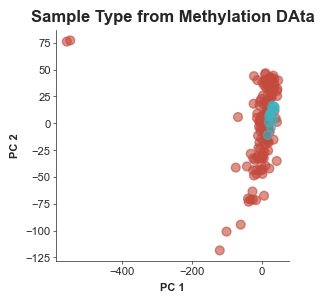

In [87]:
from sciviso import *
from sklearn.decomposition import PCA
import os
cols = list(sample_df['Sample'].values)

vals = meth_df[cols].values.T

# For vis replace Nan with mean - we'll impute later
vals = np.nan_to_num(vals, np.mean(np.mean(vals)))

pca = PCA(n_components=2)
pca_values = pca.fit_transform(vals)
var_ratio = pca.fit(vals).explained_variance_ratio_
plt.rcParams['figure.figsize'] = [4, 4]
vis_df = pd.DataFrame()
vis_df['PC_1'] = pca_values[:, 0]
vis_df['PC_2'] = pca_values[:, 1]
vis_df['CondID'] = sample_df['CondID'].values
vis_df['Colour'] = ['#C24B3D' if c == 1 else '#3DB4C2' for c in vis_df['CondID'].values]

sc = Scatterplot(vis_df, x='PC_1', y='PC_2', title=f'Sample Type from Methylation DAta', xlabel='PC 1', ylabel='PC 2',
                 add_legend=True, colour=vis_df['Colour'].values,
                 config={'s': 40, 'opacity': 0.6, 'figsize': (3, 3)})
sc.plot()
fig_dir = ''
plt.savefig(os.path.join(fig_dir, f'{cancer}_CpG_scatterPCASampleType.svg'))
plt.show()

In [88]:
from sciutil import SciUtil

u = SciUtil()

cols = list(sample_df['Sample'].values)

meth_df = meth_df.replace(0, 0.001)
meth_df = meth_df.replace(1.0, 0.999)

mean_meth = np.nanmean(meth_df[cols].values, axis=1)
u.dp(['Methylation size: ', meth_df.shape, 'Mean meth:', mean_meth])

meth_df = meth_df[mean_meth > 0.05]

u.dp(['Methylation size after 0.05 filter: ', meth_df.shape, 'Mean meth:', mean_meth])

mean_meth = np.nanmean(meth_df[cols].values, axis=1)
meth_df = meth_df[mean_meth < 0.95]

u.dp(['Methylation size after 0.95 filter: ', meth_df.shape, 'Mean meth:', mean_meth])

corr = meth_df[cols].corr()
# Print out the minimum correlation:
mean_cor = np.nanmean(corr, axis=1)
corr['mean_corr'] = mean_cor
corr.sort_values(by=['mean_corr'])

--------------------------------------------------------------------------------
Methylation size: 	(835683, 158)	Mean meth:	[0.44019354 0.70037499 0.91553865 ... 0.02833537 0.05938159 0.10197949]	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Methylation size after 0.05 filter: 	(732359, 158)	Mean meth:	[0.44019354 0.70037499 0.91553865 ... 0.02833537 0.05938159 0.10197949]	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Methylation size after 0.95 filter: 	(720518, 158)	Mean meth:	[0.44019354 0.70037499 0.91553865 ... 0.15481479 0.05938159 0.10197949]	
--------------------------------------------------------------------------------


,C3L.00026_Tumor_CpG,C3L.00165_Tumor_CpG,C3L.00359_Tumor_CpG,C3L.00610_Tumor_CpG,C3L.00765_Tumor_CpG,C3L.00766_Tumor_CpG,C3L.00789_Tumor_CpG,C3L.00790_Tumor_CpG,C3L.00792_Tumor_CpG,C3L.00796_Tumor_CpG,...,C3L.00917_Normal_CpG,C3L.01286_Normal_CpG,C3L.01836_Normal_CpG,C3N.00149_Normal_CpG,C3N.00150_Normal_CpG,C3N.00242_Normal_CpG,C3N.00733_Normal_CpG,C3N.00852_Normal_CpG,C3N.01200_Normal_CpG,mean_corr
C3L.01951_Tumor_CpG,-0.029294,-0.023183,-0.030211,-0.027603,-0.027229,-0.030729,-0.029453,-0.026631,-0.023030,-0.029301,...,-0.033212,-0.031036,-0.034282,-0.030294,-0.029641,-0.030132,-0.033417,-0.030231,-0.031343,-0.018011
C3N.01989_Tumor_CpG,-0.014320,-0.016623,-0.017912,-0.011861,-0.014844,-0.016090,-0.020133,-0.017824,-0.015480,-0.019295,...,-0.020173,-0.019571,-0.019760,-0.019168,-0.019169,-0.018913,-0.020577,-0.019548,-0.019338,-0.008928
C3N.00492_Tumor_CpG,0.762206,0.738251,0.774177,0.770567,0.790192,0.810972,0.781709,0.784935,0.755044,0.781627,...,0.815090,0.816670,0.826124,0.823379,0.820669,0.815736,0.823630,0.810000,0.813970,0.754959
C3N.01180_Tumor_CpG,0.820488,0.783562,0.835864,0.812677,0.818414,0.844474,0.822850,0.806529,0.785470,0.831647,...,0.852401,0.844647,0.850279,0.840527,0.843877,0.840850,0.840363,0.837247,0.831535,0.793308
C3L.00968_Tumor_CpG,0.774281,0.822927,0.793468,0.781026,0.815347,0.810393,0.783321,0.824132,0.778079,0.799179,...,0.794965,0.819565,0.802866,0.814379,0.819312,0.826755,0.802726,0.824450,0.819567,0.800255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C3L.00991_Tumor_CpG,0.883903,0.913890,0.894454,0.909129,0.947082,0.935335,0.913068,0.954413,0.910805,0.919773,...,0.912620,0.934171,0.905417,0.937279,0.936968,0.951021,0.910335,0.932439,0.934860,0.906926
C3N.02063_Tumor_CpG,0.883394,0.903444,0.897458,0.904546,0.943125,0.937921,0.909750,0.944450,0.899615,0.911705,...,0.922644,0.945113,0.917285,0.942522,0.945195,0.957136,0.926377,0.948452,0.945552,0.907453
C3N.00242_Normal_CpG,0.908279,0.899764,0.931756,0.913920,0.953543,0.968855,0.926340,0.948436,0.899923,0.924038,...,0.970601,0.979942,0.967603,0.979812,0.980513,1.000000,0.966867,0.978169,0.978638,0.908891
C3L.02202_Tumor_CpG,0.901732,0.909165,0.909710,0.919339,0.955165,0.947347,0.926160,0.959060,0.906622,0.931375,...,0.927602,0.943092,0.920965,0.947390,0.947701,0.957849,0.921329,0.938988,0.943135,0.911146


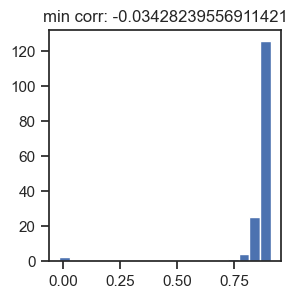

--------------------------------------------------------------------------------
                         Methylation columns to omit: 	                         
--------------------------------------------------------------------------------
C3L.01951_Tumor_CpG
C3N.01989_Tumor_CpG
--------------------------------------------------------------------------------
                            New size:	(720518, 156)	                            
--------------------------------------------------------------------------------


In [89]:
import matplotlib.pyplot as plt
# Plot out the mean correlation values so we can choose a good filter.
plt.hist(mean_cor, bins=20)
plt.title(f'min corr: {np.min(corr)}')
plt.show()

# Filter the shitty patients
corr_sorted = corr.sort_values(by=['mean_corr'])
corr_sorted = corr_sorted[corr_sorted['mean_corr'] < 0.7]
cols_to_omit = [c for c in corr_sorted.index]

u.dp(['Methylation columns to omit: '])

print('\n'.join(cols_to_omit))
cols_to_keep = [c for c in meth_df.columns if c not in cols_to_omit]
cpg_filtered = meth_df[cols_to_keep]

u.dp(['New size:', cpg_filtered.shape]) 

In [48]:
cpg_filtered = cpg_filtered[cpg_filtered.isnull().sum(axis=1) < len(cpg_filtered.values[0])/2]
cpg_filtered

,C3L.00026_Tumor_CpG,C3L.00165_Tumor_CpG,C3L.00359_Tumor_CpG,C3L.00610_Tumor_CpG,C3L.00765_Tumor_CpG,C3L.00766_Tumor_CpG,C3L.00789_Tumor_CpG,C3L.00790_Tumor_CpG,C3L.00792_Tumor_CpG,C3L.00796_Tumor_CpG,...,C3N.02726_Tumor_CpG,C3N.02761_Tumor_CpG,C3N.02763_Tumor_CpG,C3N.02811_Tumor_CpG,C3N.02945_Tumor_CpG,C3N.03018_Tumor_CpG,C3N.03019_Tumor_CpG,C3N.03020_Tumor_CpG,C3N.03021_Tumor_CpG,C3N.00149_Normal_CpG
Locus,,,,,,,,,,,,,,,,,,,,,
cg00000029,0.620917,0.328791,0.464271,0.557367,0.627089,0.647848,0.546622,0.592028,0.802045,0.697934,...,0.444012,0.337082,0.570233,0.365759,0.316070,0.393935,0.288154,0.676817,0.262431,0.348554
cg00000109,0.622101,0.847529,0.845261,0.624368,0.779402,0.818038,0.618067,0.803046,0.682635,0.504367,...,0.620154,0.820035,0.639597,0.599622,0.475616,0.369462,0.757804,0.661171,0.852063,0.848502
cg00000155,0.917186,0.918417,0.913586,0.937239,0.920251,0.915483,0.927661,0.920605,0.930799,0.926790,...,0.910009,0.927637,0.935045,0.919840,0.926848,0.718042,0.916902,0.924569,0.931407,0.917669
cg00000158,0.491484,0.640712,0.485402,0.564475,0.813202,0.755919,0.603831,0.807621,0.580527,0.495015,...,0.626768,0.735793,0.578202,0.761671,0.580767,0.659568,0.567702,0.487106,0.448556,0.838733
cg00000165,0.060553,0.434139,0.065843,0.087154,0.080263,0.112749,0.068346,0.123710,0.392567,0.068314,...,0.167967,0.087837,0.081238,0.347296,0.086564,NaN,0.224560,0.074014,0.084169,0.112848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ch.X.967194F,0.210875,0.164560,0.217120,0.160414,0.145514,0.146273,0.109516,0.165978,0.150711,0.178849,...,0.252534,0.236430,0.191318,0.174483,0.190974,0.197888,0.250562,0.204243,0.445455,0.196314
ch.X.97129969R,0.102605,0.102786,0.076953,0.029775,0.052918,0.066904,0.051890,0.081144,0.043100,0.119076,...,0.094084,0.163127,0.083743,0.097412,0.009941,0.105870,0.087724,0.087858,0.117626,0.050538
ch.X.97133160R,0.154442,0.131476,0.083164,0.054798,0.077421,0.071801,0.044828,0.069485,0.037700,0.098510,...,0.242202,0.186219,0.107361,0.115340,0.141017,NaN,0.245311,0.160291,0.187966,0.104793


In [90]:
sample_df['CondID'].value_counts()

CondID
1    146
0     12
Name: count, dtype: int64

/Users/arianemora/miniconda3/envs/sircle/lib/python3.10/site-packages/sciviso/scatterplot.py:114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(vis_df[x].values, vis_df[y].values, c=self.colour, alpha=self.opacity,


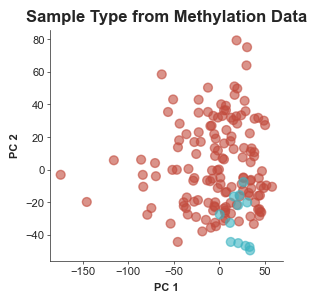

In [91]:
from sciviso import *
from sklearn.decomposition import PCA
import os

sample_df = sample_df[~sample_df['Sample'].isin(cols_to_omit)]
cols = list(sample_df['Sample'].values)

vals = cpg_filtered[cols].values.T

# For vis replace Nan with mean - we'll impute later
vals = np.nan_to_num(vals, np.mean(np.mean(vals)))

pca = PCA(n_components=2)
pca_values = pca.fit_transform(vals)
var_ratio = pca.fit(vals).explained_variance_ratio_
plt.rcParams['figure.figsize'] = [4, 4]
vis_df = pd.DataFrame()
vis_df['PC_1'] = pca_values[:, 0]
vis_df['PC_2'] = pca_values[:, 1]
vis_df['CondID'] = sample_df['CondID'].values
vis_df['Colour'] = ['#C24B3D' if c == 1 else '#3DB4C2' for c in vis_df['CondID'].values]

sc = Scatterplot(vis_df, x='PC_1', y='PC_2', title=f'Sample Type from Methylation Data', xlabel='PC 1', ylabel='PC 2',
                 add_legend=True, colour=vis_df['Colour'].values,
                 config={'s': 40, 'opacity': 0.6, 'figsize': (3, 3)})
sc.plot()
fig_dir = ''
plt.savefig(os.path.join(fig_dir, f'{cancer}_CpG_scatterPCASampleType.svg'))
plt.show()

In [92]:
cpg_filtered.to_csv(f'{cancer}_filtered_CpG.csv')

In [93]:
sample_df.to_csv(f'{cancer}_filtered_samples_CpG.csv', index=False)